> ### EEE3314: Introduction to Artificial Intelligence

# Assignment \# IX:  Convolutional Neural Networks

### *Assignement Instructions:*
- **Due date**: 11 PM, Dec. 18, 2021
- **File name**: ID_Name_HW9.ipynb
- Write a program implementing a particular algorithm to solve a given problem.   
- **Analyze the algorithm, theoretically and empirically. Report and discuss your results.**

### *Collaboration policy:*
- You may discuss the questions with your friends, but each student writes their own codes and answers.  
- **Cheating is strictly prohibited, and will be considered academic dishonesty. This is not how you want to start your career as an engineer.**
We expect that most students can distinguish between helping other students and cheating. Explaining the meaning of a question or discussing a way of approaching a solution is an interaction. But you should write your homework solution strictly by your so that your hands and eyes can help you internalize the subject matter. You should acknowledge everyone whom you have worked with, or who has given you any significant ideas about the homework.
- Signiture: <span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span>

In [1]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)

OS information
Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic

Is GPU available?
True

GPU information
Mon Dec  6 01:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                   

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-12-06 01:08:00.938607


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/Colab

/content/drive/My Drive/Colab


## PyTorch Tutorial
PyTorch is one of the latest deep learning framework developed by Facebook, and open sourced on GitHub since 2017. You can read more about its development in the research paper "Automatic Differentiation in PyTorch." PyTorch is gaining popularity for its simplicity, ease of use, dynamic computational graph and efficient memory usage. (reference : https://builtin.com/data-science/pytorch-vs-tensorflow)

### Example: PyTorch implementation for Assignment 8   

Recall the assignment 8 which contains a classification problem of $\texttt{moons}$ dataset from ```sklearn.datasets```. In the assignment 8, we implemented forward and backward propagation methods using numpy, and trained a neural network with the following configuration.
 - **Input size**: 2
 - **the number ot hidden units** : [10, 10] 
 - **Output size**: 2
 - **Activations** : [sigmoid, tanh, softmax]
 - **Loss function**: Cross entropy loss
 - **Optimizer**: Gradient descent
 - **Learning rate** = 0.001
 - **Number of epochs** = 50000
 
Let's reproduce it by using a pytorch framework. First, load the $\texttt{moons}$ dataset from ```sklearn.dataset``` and visualize samples.

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # We use CPUs for training models.

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets


np.random.seed(0)
# dataset
X, y = sklearn.datasets.make_moons(300, noise = 0.25)

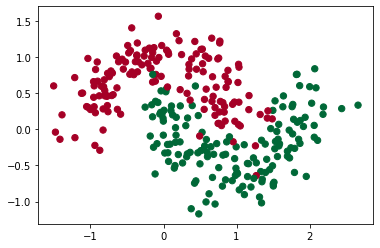

In [7]:
plt.scatter(X[:,0], X[:,1], s = 40, c=y, cmap=plt.cm.RdYlGn)

In [8]:
from project9 import plot_decision_boundary, get_accuracy, get_prediction
import torch
import torch.optim as optim
import torch.nn as nn

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)


The following cell shows how to define a neural network with three layers in PyTorch. The function ```nn.Linear()``` constructs a fully connected layer with arguments ```in_features``` and ```out_features```, dimensions of input and output features, respectively. The ```forward``` function defines a forward propagation of an input tensor ```x```. Note that a $\texttt{ReLU}$ and a $\texttt{sigmoid}$ activations are used for the first and second layers.

In [9]:
class MoonMLP(nn.Module):
    def __init__(self):
        super(MoonMLP, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        logits = self.fc3(x) # It doesn't need to apply softmax activation because objective function "torch.nn.CrossEntropyLoss" contains softmax function for the logits. 
        return logits

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
moon_mlp_model = MoonMLP() # instanciation
moon_mlp_model.to(device) # to GPU
print(moon_mlp_model)

MoonMLP(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


Next, we have to define an optimizer and a loss function. PyTorch provides modules for optimizers and loss functions. See the official documentations for [```optim.SGD```](https://pytorch.org/docs/master/optim.html#torch.optim.SGD) and [```torch.nn.CrossEntropyLoss```](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss).


In [11]:
learning_rate = 0.001

# define the optimizer
optimizer = optim.SGD(moon_mlp_model.parameters(), lr=learning_rate)

# define the loss function
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

Finally, we can train our model. For each iteration, training models typically consists of five steps in PyTorch as follows:
1. Initializing gradients to zero
2. Forward propagation
3. Calculating a loss value
4. Calculating gradients through a backward propagation
5. Updating model parameters 


In [12]:
total_epoch = 50000
# conver numpy to torch.tensor type
X_tensor = torch.Tensor(X)
y_tensor = torch.LongTensor(y)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

tbar = tqdm.notebook.tqdm(range(total_epoch), total=total_epoch)

# set the model to train-mode. 
moon_mlp_model.train()
for epoch in tbar:
    
    # step 1) initialize gradients to zero 
    optimizer.zero_grad()
    
    # step 2) forward propagation
    output = moon_mlp_model(X_tensor)
    
    # step 3) calculate loss
    loss = criterion(output, y_tensor)
    
    # step 4) calculate gradients through a backward propagation
    loss.backward()
    
    # step 5) update model parameters
    optimizer.step()
    
    # print the progress
    if epoch % 5000 == 4999:
        # set the model to evaluation-mode
        moon_mlp_model.eval() 
        pred = get_prediction(output)
        accuracy = get_accuracy(pred, y_tensor)
    
        desc = '%d-th epoch, loss: %.2f, accuracy: %.2f'%(epoch+1, loss.item(), accuracy)
        tbar.set_description(desc)
        

  0%|          | 0/50000 [00:00<?, ?it/s]

> *tqdm* makes it convinient to check a progress of 'for or while loop'. 


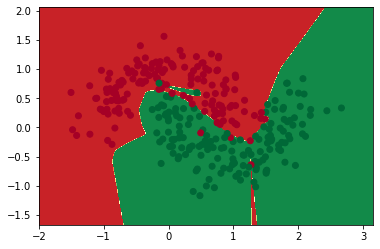

In [13]:
plot_decision_boundary(moon_mlp_model, X, y)

In this example, we have shown how to build an MLP model, to use a pre-defined loss function and an optimizer, and to train the model using PyTorch.

## Problem statement

We will implement a convolutional neural network(CNN) and multilayer perceptron (MLP) for tetris block classification.

<img src = "https://i.imgur.com/ZwfnL78.png">

In this assignment, we will solve the tetris block classification task using MLP and CNNs. We will then verify the reason why CNNs are better than MLP for such tasks in computer vision. Finally, we will investigate three properties of CNNs (robust to translation, and sensitive to scale and rotation variation).

### P1. MLP

P1.1 Implement the multilayer perceptron model (```MLP``` class) and the train function (```train``` function) that inputs model, optimizer, criterion, train dataset, and total epcoh, and train the model (step1-5). Run the code provided to train the MLP model. Analyze the results in terms of the number of training samples and the test accuracies. *(15 points)*

The configurations for the model are as follows:  

- **Model & training settings**
    - **architecture**: Linear(64) - relu - Linear(8) - ReLU - Linear(7)
    > We denote a fully connected layer with m hidden units by Linear(m).
    - **loss function**: CrossEntropyLoss(reduction='mean').
    - **optimizer**: Adagrad with learning_rate of 0.01.
- **Train set**
    - **tetris_2000**: tetris dataset with 2000 samples.
    - **tetris_500**: tetris dataset with 500 samples.
    - **tetris_100**: tetris dataset with 100 samples. 
    - For all datasets, the batch size is 20, random position is ```True```, and random scale and rotation are ```False```.
    
- **Test set**
    - test_set: tetris dataset with 200 samples, random position is ```True```, and random scale and rotation are ```False```.
- **Epochs**
    - 200 for tetris_2000, 400 for tetris_500, and 800 for tetris_100

### P2. CNN 

P2.1 Run the code provided to train the CNN model (```CNN``` class). Analyze the results in terms of the number of training samples and the test accuraies. *(10 points)*  

The configurations for the model are as follows:  

- **Model & training settings**
    - **CNN architecture**: Conv(1,16,9,0) - MaxPool(24) - ReLU - Linear(7)
    > We denote a convolutional layer with m input feature channels, n output feature channels, k kernel size and p padding number by Conv(m, n, k, p).
    - **loss function**: CrossEntropyLoss(reduction='mean').
    - **optimizer**: Adagrad with learning_rate of 0.01.
- **Train set**
    - **tetris_2000**: tetris dataset with 2000 samples.
    - **tetris_500**: tetris dataset with 500 samples.
    - **tetris_100**: tetris dataset with 100 samples. 
    - For all datasets, the batch size is 20, random position is ```True```, and random scale and rotation are ```False```.  
    
- **Test set**
    - test_set: tetris dataset with 200 samples, random position is ```True```, and random scale and rotation are ```False```.  
    
- **Epochs**
    - 200 for tetris_2000, 400 for tetris_500, and 800 for tetris_100    


P2.2 Implmenet a deeper CNN model (```DeeperCNN``` class) following the below configurations. Write down the code to train the deeper CNN model. Analyze and contrast CNN (in P2.1) and DeeperCNN models in terms of the number of parameters, test accuracy and generalizability. *(25 points)*

The configurations for the model are as follows:  

- **Model & training settings**
    - **CNN architecture**: Conv(1,4,3,1) - ReLU - Conv(4,4,3,1) - MaxPool(2) - ReLU - Conv(4,8,3,1) - MaxPool(2) - ReLU - Conv(8,8,3,1) - MaxPool(2) - ReLU - Conv(8,16,3,1) - MaxPool(2) - ReLU - Conv(16,16,3,1) - MaxPool(2) - ReLU - Linear(8) - ReLU - Linear(7)
    > We denote a convolutional layer with m input feature channels, n output feature channels, k kernel size and p padding number by Conv(m, n, k, p).
    - **loss function**: CrossEntropyLoss(reduction='mean').
    - **optimizer**: Adagrad with learning_rate of 0.01.
- **Train set**
    - **tetris_2000**: tetris dataset with 2000 samples.
    - For the dataset, the batch size is 20, random position is ```True```, and random scale and rotation are ```False```.  
    
- **Test set**
    - test_set: tetris dataset with 200 samples, random position is ```True```, and random scale and rotation are ```False```.  
    
- **Epochs**
    - 200

### P3. Analysis (CNN)

P3.1 Run the code provided to see that CNN (```CNN``` class) is more translation-invariant than MLP (```MLP``` class). Analyze and contrast the CNN and the MLP in terms of the number of parameters. That is, describe the reason why the CNN model shows better performance despite it has fewer model parameters than the MLP. *(25 points)*  

The configurations for the dataset are as follows:  

- **Train set**
    - **train_set_without_randomness**: tetris dataset with 1000 samples.
    - The batch size is 20, and random position, random scale and rotation are ```False```.  
    
- **Test set**
    - test_set: tetris dataset with 200 samples, random position is ```True```, and random scale and rotation are ```False```.  

P3.2 Verify that the CNN model (```CNN``` class) is sensitive to scale and rotation variations. Construct your own test dataset using the ```make_tetris_dataset``` function and write the code to check them. Analyze the results in terms of the test accuracy. *(20 points)*  

- Note that:
    - random_scale=True : block_sizes are uniformly selected from [4, 8, 12]
    - random_rotation=True : rotations are uniformly selected from [0, 90, 180, 270] 
  
P3.3 Propose and implement your own method to overcome the limitations. *(5 points)* 

---

## Results

### Prepare datasets
For the tetris block classification task, we provide a data generating function which selects different samples depending on the arguments: 
- ```make_tetris_dataset(data_num, batch_size, random_position, random_scale, random_rotation)```
- Note that the defalut sizs for an image and a block are 32 and 12, respectively. You can find them in thre ```project9.py``` file.

Let's visualize the dataset for various arguments settings.  

In [14]:
from project9 import make_tetris_dataset, visualize_dataset

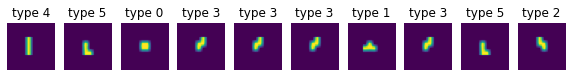

In [15]:
plot_num = 10
random_position = False
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

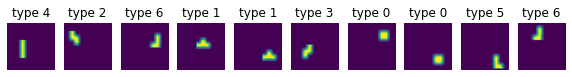

In [16]:
plot_num = 10
random_position = True
random_scale = False
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

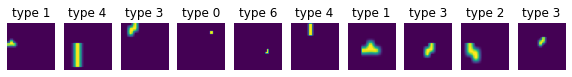

In [17]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = False
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

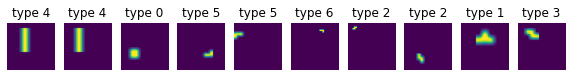

In [18]:
plot_num = 10
random_position = True
random_scale = True
random_rotation = True
dataset = make_tetris_dataset(plot_num, 1, random_position, 
                         random_scale, random_rotation)
visualize_dataset(dataset, plot_num)

### P1.1

In [19]:
from project9 import MLP, train, evaluate

In [20]:
batch_size = 20
random_position = True
random_scale = False
random_rotation = False

train_num = 2000
tetris_2000 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

train_num = 500
tetris_500 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

train_num = 100
tetris_100 = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

test_num = 200
test_set = make_tetris_dataset(test_num, batch_size, random_position, random_scale, random_rotation)

In [21]:
mlp = MLP()
mlp.to(device)
print(mlp)
print(f" number of parameters: {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 200

optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=tetris_2000, total_epoch=total_epoch)
accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=test_set)

print(accuracy)

MLP(
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
)
 number of parameters: 66183


  0%|          | 0/200 [00:00<?, ?it/s]

0.79


In [22]:
mlp = MLP()
mlp.to(device)
print(mlp)
print(f" number of parameters: {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 400

optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=tetris_500, total_epoch=total_epoch)
accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=test_set)

print(accuracy)

MLP(
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
)
 number of parameters: 66183


  0%|          | 0/400 [00:00<?, ?it/s]

0.425


In [23]:
mlp = MLP()
mlp.to(device)
print(mlp)
print(f" number of parameters: {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 800

optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=tetris_100, total_epoch=total_epoch)
accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=test_set)

print(accuracy)

MLP(
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
)
 number of parameters: 66183


  0%|          | 0/800 [00:00<?, ?it/s]

0.23500000000000001


Describe your analysis here

---

### P2.1

In [24]:
from project9 import CNN

In [25]:
cnn = CNN()
cnn.to(device)
print(cnn)
print(f" number of parameters: {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 200

optimizer = optim.Adagrad(cnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=cnn, optimizer=optimizer, criterion=criterion, train_dataset=tetris_2000, total_epoch=total_epoch)
accuracy = evaluate(model=cnn, criterion=criterion, test_dataset=test_set)

print(accuracy)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=7, bias=True)
)
 number of parameters: 1431


  0%|          | 0/200 [00:00<?, ?it/s]

1.0


In [26]:
cnn = CNN()
cnn.to(device)
print(cnn)
print(f" number of parameters: {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 400

optimizer = optim.Adagrad(cnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=cnn, optimizer=optimizer, criterion=criterion, train_dataset=tetris_500, total_epoch=total_epoch)
accuracy = evaluate(model=cnn, criterion=criterion, test_dataset=test_set)

print(accuracy)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=7, bias=True)
)
 number of parameters: 1431


  0%|          | 0/400 [00:00<?, ?it/s]

1.0


In [27]:
cnn = CNN()
cnn.to(device)
print(cnn)
print(f" number of parameters: {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 800

optimizer = optim.Adagrad(cnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=cnn, optimizer=optimizer, criterion=criterion, train_dataset=tetris_500, total_epoch=total_epoch)
accuracy = evaluate(model=cnn, criterion=criterion, test_dataset=test_set)

print(accuracy)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=7, bias=True)
)
 number of parameters: 1431


  0%|          | 0/800 [00:00<?, ?it/s]

1.0


Describe your analysis here

---

### P2.2

In [28]:
from project9 import DeeperCNN

In [29]:
### CODE HERE ###
raise NotImplementedError("Erase this line and write down your code.")
#################

DeeperCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=7, bias=True)
)
 number of parameters: 4755


  0%|          | 0/200 [00:00<?, ?it/s]

0.9949999999999999


Describe your analysis here

---

### P3.1

In [30]:
batch_size = 20
random_position = False
random_scale = False
random_rotation = False

train_num = 1000
train_set_without_randomness = make_tetris_dataset(train_num, batch_size, random_position, random_scale, random_rotation)

In [31]:
mlp = MLP()
mlp.to(device)
print(mlp)
print(f" number of parameters: {sum(p.numel() for p in mlp.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 600

optimizer = optim.Adagrad(mlp.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=mlp, optimizer=optimizer, criterion=criterion, train_dataset=train_set_without_randomness, total_epoch=total_epoch)
accuracy = evaluate(model=mlp, criterion=criterion, test_dataset=test_set)

print(accuracy)

MLP(
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
)
 number of parameters: 66183


  0%|          | 0/600 [00:00<?, ?it/s]

0.14000000000000004


In [32]:
cnn = CNN()
cnn.to(device)
print(cnn)
print(f" number of parameters: {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}")

learning_rate = 0.01
total_epoch = 400

optimizer = optim.Adagrad(cnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
train(model=cnn, optimizer=optimizer, criterion=criterion, train_dataset=train_set_without_randomness, total_epoch=total_epoch)
accuracy = evaluate(model=cnn, criterion=criterion, test_dataset=test_set)

print(accuracy)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=7, bias=True)
)
 number of parameters: 1431


  0%|          | 0/400 [00:00<?, ?it/s]

0.945


Describe your analysis here

---

### P3.2

In [ ]:
### CODE HERE ###
raise NotImplementedError("Erase this line and write down your code.")
#################

Describe your analysis here

---

### P3.3

In [ ]:
### CODE HERE ###
raise NotImplementedError("Erase this line and write down your code.")
#################

Descrieb your analysis here

---